In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kuaizi as kz
from astropy.table import Table
import astropy.units as u

from kuaizi.display import display_single
from astropy.io import fits

#from tiger_cutout_hsc import cutout_one, prepare_catalog # generate_cutout, get_psf
#import lsst.daf.persistence as dafPersist

In [2]:
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/tigress/jiaxuanl/Data/')

'/tigress/jiaxuanl/Data/HSC/LSBG'

### Adaptive cutout size

In [46]:
cat = Table.read('./Catalog/random_candy_sample_210313.csv')
cat['Seq'] = np.arange(0, len(cat)) # add an index
## Adaptive cutout size??  
# Normal objects, use 1.0 arcmin cutout.
# Radius > 20 arcsec, use 1.5 arcmin cutout.
# Radius > 30 arcsec, use 2.0 arcmin cutout.
size = np.ones(len(cat)) * 1.0 * u.arcmin

size[cat['flux_radius_ave_i'] > 20] = 1.5 * u.arcmin
size[cat['flux_radius_ave_i'] > 30] = 2 * u.arcmin

cat['cutout_size'] = size
cat.write('./Catalog/candy_sample_210313.fits', overwrite=True)

### Generate cutout

In [59]:
from s18a_batch_cutout import batch_cutout
# cat['radius'] is always the cutout size we should use!!!!
batch_cutout('./Catalog/candy_sample_210313.fits', 
             size='cutout_size',
            unit='arcmin',
            bands='grizy',
            ra_name='ra',
            dec_name='dec',
            name='Seq',
            prefix='candy',
            output='./Cutout/Candy',
            label='deepCoadd_calexp',
            root='/tigress/HSC/DR/s18a_wide',
            njobs=2,
            psf=True,)


 Number of jobs: 2
    - Generate cutouts for 20 galaxies in g-band.
    - Generate cutouts for 20 galaxies in r-band.
    - Generate cutouts for 20 galaxies in i-band.
    - Generate cutouts for 20 galaxies in z-band.
    - Generate cutouts for 20 galaxies in y-band.
Elapsed time: 330.84 s


In [7]:
from kuaizi.display import display_single
from astropy.io import fits

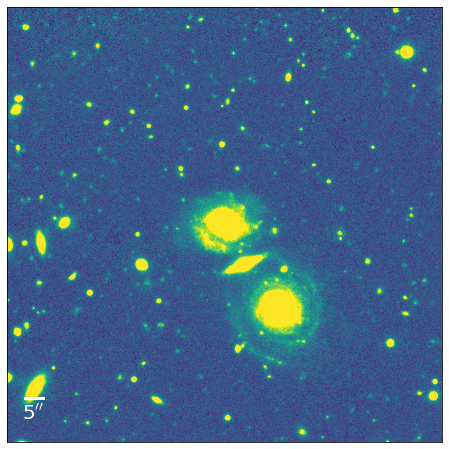

In [9]:
img = fits.open('./Cutout/Candy/candy_14_i.fits')[1].data
display_single(img);

In [45]:
cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')
cat[:5]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,objectid,Seq,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,arcsec,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,float64,bytes54,float64,bool,bool
225.3020883,1.0550868,26.224,17.616,82.68,0.328,20.0629,18.5655,18.0075,14.22708,22.39902,27.266820128426676,26.55830937698006,1.1643505268070824,1.2578408501384883,0.9366706388175572,0.12434132134058919,0.08811196015814717,0.06288217147907928,9621,"3,6",-1,42352,42352,0,1.5,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_0,1.5,True .. True,True .. True
181.0873682,-1.5183761,53.428,42.355,-68.95,0.207,18.3062,17.8858,17.8293,14.193396,15.345876000000002,25.70770227989263,25.478894362201697,1.1545371610349655,-0.035240274241365416,0.055489525447205645,0.06421546096516757,0.045504986412372064,0.032475186723801105,9106,"6,8",-1,32953,32953,1,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_1,1.0,True .. True,True .. True
190.2022409,0.4494237,62.347,32.252,-20.65,0.483,17.1944,16.5843,16.3879,9.581712,12.665184,23.52783882994563,23.21341914966895,1.0213855491325439,0.49571079112197586,0.35251549764511914,0.051770908825189185,0.036686406470308824,0.02618169994716496,9597,"1,2",-1,62597,62597,2,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_2,1.0,True .. True,True .. True
333.6455774,1.6049543,15.95,5.242,13.16,0.671,21.8598,20.8905,20.4607,9.557184,16.077432,28.242039019042227,28.213308439789063,1.3677127872658572,0.14076629586789444,0.19316048229509267,0.10790229377916456,0.07646277607425488,0.054568589647056624,9936,"2,1",-1,56240,56240,3,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_3,1.0,True .. True,True .. True
139.8679525,3.7603522,23.143,15.864,-11.75,0.315,20.765,19.1098,18.8354,8.567496,16.728096,26.58988343975888,26.844953931059088,1.0778980753223444,0.6939786196199077,0.47221906112762835,0.14854275517449633,0.10526181630212529,0.07512137479440194,10048,"4,4",-1,60593,60593,4,1.0,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy/candy_4,1.0,True .. True,True .. True


### Display cutouts

In [3]:
def _display_cutout_rgb(images, ax=None):
    import scarlet
    from scarlet.display import AsinhMapping

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    # Display
    norm = AsinhMapping(minimum=-0.3, stretch=1, Q=0.5)
    img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
    plt.imshow(img_rgb, origin='lower')
    ax.axis('off')
    
    if ax is None:
        return fig
    return ax

In [4]:
CANDY_DIR = '/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/Candy'

In [83]:
# Display each cutout

for i in range(60, 300):
    images = np.asarray([fits.open(f'{CANDY_DIR}/candy_{i}_{filt}.fits')[1].data for filt in 'grizy'])
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = _display_cutout_rgb(images, ax=ax)
    plt.savefig(f'/tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy_{i}_cutout.png', dpi=50, bbox_inches='tight')
    plt.close()

In [84]:
!mv /tigress/jiaxuanl/Data/HSC/LSBG/Figure/candy_*_cutout.png /tigress/jiaxuanl/public_html/candy/cutout_figure/

### Generate html

In [85]:
import os
import re

In [110]:
# find existing cutout rgb images
figlist = os.listdir('/tigress/jiaxuanl/public_html/candy/cutout_figure/')
figlist = [item for item in figlist if '_cutout.png' in item] # only select png
index_list = [int(re.findall('\d+', item)[0]) for item in figlist]
index_list = np.sort(index_list)

len(index_list)

300

In [111]:
col_num = 7
row_num = 4
page_num = len(index_list) // (col_num * row_num) + 1

In [114]:
for k in range(page_num):
    f = open(f'/tigress/jiaxuanl/public_html/candy/cutout_figure/page{k + 1}.html', 'w')
    f.write('<!DOCTYPE html><html><head><link rel="stylesheet" type="text/css" href="../../mystyle.css"></head><body> \n')
    f.write('<div class="header"><h1>Candy Sample Cutout</h1></div> \n')
    f.write('<div class="navigator">')
    
    if k == 0:
        f.write('<a href="#" class="previous">&laquo; Previous</a> \n')
    else:
        f.write(f'<a href="page{k}.html" class="previous">&laquo; Previous</a> \n')
    
    f.write(f'<a href="#" class="current">Page {k + 1}</a> \n')
    
    if k == page_num - 1:
        f.write('<a href="#" class="next">Next &raquo;</a> \n')
    else:
        f.write(f'<a href="page{k + 2}.html" class="next">Next &raquo;</a> \n')
        
    f.write('</div> \n')
    
    for i in range(col_num * row_num):
        if (i) % col_num == 0 or i == 0:
            f.write('<div class="column"> \n')
        ind = col_num * row_num * k + i
        if ind >= len(index_list):
            f.write('</div> \n')
            break
        f.write(f'      <figure> <img src="candy_{index_list[ind]}_cutout.png"> <figcaption>Candy {index_list[ind]}</figcaption> </figure> \n')
        if (i + 1) % 7 == 0:
            f.write('</div> \n')
    
    

    f.write('</body></html> \n')
    f.close()

In [113]:
page_num

11